# PLUMED Masterclass 22.12
## Liquid-solid chemical potential differences with the environment similarity CV

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os.path
from scipy import interpolate
from scipy.ndimage import gaussian_filter
import ase
import ase.io as aseio
import nglview
import ipywidgets

In [10]:
font = {'family' : 'serif',
'serif'   : 'palatino',
'style'   : 'normal',
'variant'   : 'normal',
'stretch'   : 'normal',
'weight'   : 'normal',
'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


## Exercise 1: Choosing reference environments and appropriate $\sigma$ values <a name="ex1"></a>

### Distributions of $k(\chi,\chi')$

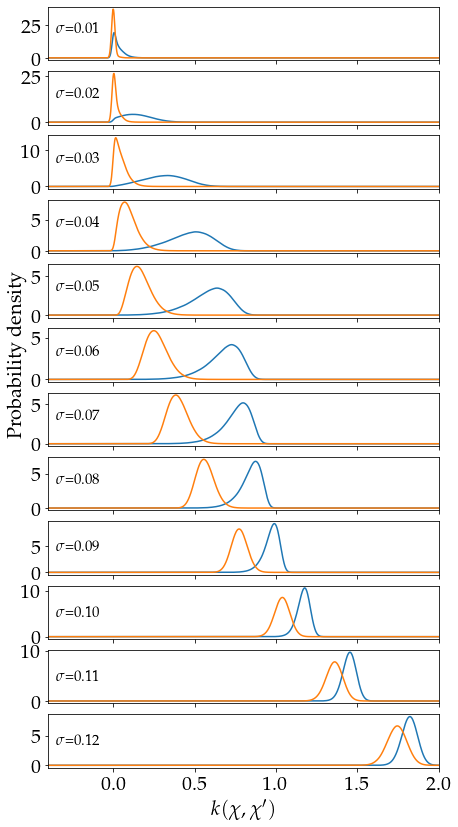

In [13]:
sigma=np.arange(0.01,0.13,0.01)
overlap=np.zeros(sigma.shape[0])
plt.rcParams["figure.figsize"] = (3.5*2,7*2)
fig, axs= plt.subplots(sigma.shape[0],sharex=True) #,sharey=True)

for i in range(sigma.shape[0]):
    string='{:.2f}'.format(sigma[i])
    data_bcc=np.genfromtxt("1-distributions/bcc/histo-"+string)
    data_liquid=np.genfromtxt("1-distributions/liquid/histo-"+string)
    axs[i].plot(data_bcc[:,0],data_bcc[:,1])
    axs[i].plot(data_liquid[:,0],data_liquid[:,1])
    axs[i].set_xlim([-0.4,2])
    axs[i].text(-0.35,np.amax(data_liquid[:,1])/2,r"$\sigma$=" + string,fontsize=15)
    #print(1.8-i*1.9/sigma.shape[0],20.0-i*20.0/sigma.shape[0])
axs[5].set_ylabel("Probability density")
axs[sigma.shape[0]-1].set_xlabel(r"$k(\chi,\chi')$")

#plt.tight_layout()
plt.show()

Comments: Very significant overlap for extreme $\sigma$ values

Choice of $\sigma$

We use the following overlap metric between distributions $p(x)$ and $q(x)$

$\int min[p(x),q(x)] dx$

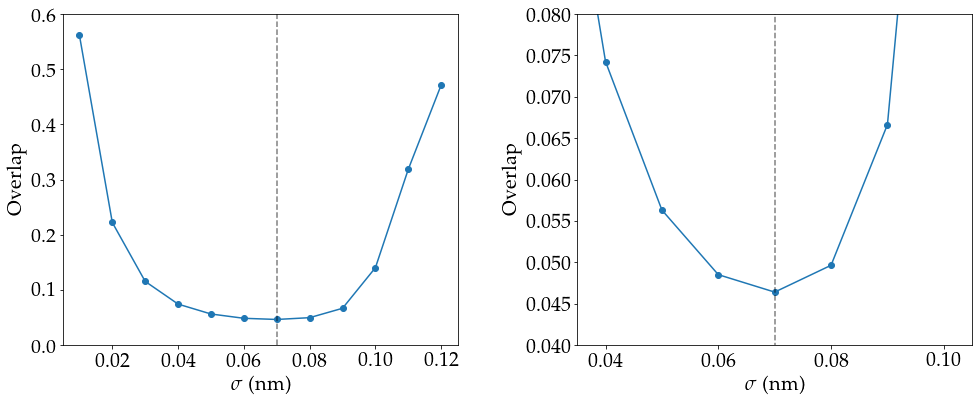

In [15]:
plt.rcParams["figure.figsize"] = (7*2,3*2)
fig, axs= plt.subplots(1,2)

sigma=np.arange(0.01,0.13,0.01)
overlap=np.zeros(sigma.shape[0])
for i in range(sigma.shape[0]):
    string='{:.2f}'.format(sigma[i])
    data_bcc=np.genfromtxt("1-distributions/bcc/histo-"+string)
    data_liquid=np.genfromtxt("1-distributions/liquid/histo-"+string)
    overlap[i]=np.trapz(np.minimum(data_bcc[:,1],data_liquid[:,1]),x=data_bcc[:,0])
axs[0].scatter(sigma,overlap)
axs[0].plot(sigma,overlap)
axs[0].plot([sigma[np.argmin(overlap)],sigma[np.argmin(overlap)]],[0,0.6],'--',color='black',alpha=0.5)
#axs[0].fill_between([0.005,0.125],[0,0],[2*np.amin(overlap),2*np.amin(overlap)],linewidth=0.,color='black',alpha=0.1)

axs[1].scatter(sigma,overlap)
axs[1].plot(sigma,overlap)
axs[1].plot([sigma[np.argmin(overlap)],sigma[np.argmin(overlap)]],[0,0.6],'--',color='black',alpha=0.5)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

axs[0].set_xlabel(r"$\sigma$ (nm)")
axs[0].set_ylabel("Overlap")
axs[0].set_ylim([0.0,0.6])
axs[0].set_xlim([0.005,0.125])

axs[1].set_ylim([0.04,0.08])
axs[1].set_xlim([0.035,0.105])
axs[1].set_xlabel(r"$\sigma$ (nm)")
axs[1].set_ylabel("Overlap")

plt.tight_layout()

plt.show()

* $\sigma=0.07$ nm minimizes the overlap and is thus a good choice to distinguish the liquid and bcc phases
* Robustness - One can choose $\sigma$ between ~0.03 and ~0.1 and still have a modest overlap 

### Maximum of distributions and threshold

Maximum of bcc distribution at  0.7975
Maximum of liquid distribution at  0.385
Equal probability densities at  0.555


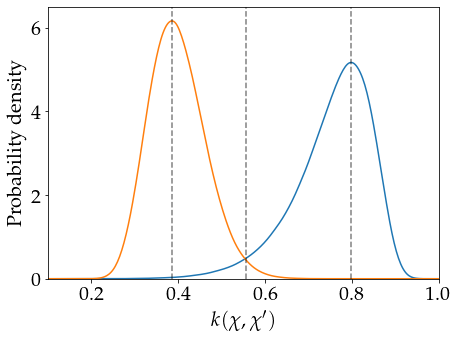

In [18]:
sigma=0.07
plt.rcParams["figure.figsize"] = (3.5*2,2.5*2)

string='{:.2f}'.format(sigma)
data_bcc=np.genfromtxt("1-distributions/bcc/histo-"+string)
data_liquid=np.genfromtxt("1-distributions/liquid/histo-"+string)
plt.plot(data_bcc[:,0],data_bcc[:,1])
plt.plot(data_liquid[:,0],data_liquid[:,1])
max_bcc=data_bcc[np.argmax(data_bcc[:,1]),0]
max_liquid=data_liquid[np.argmax(data_liquid[:,1]),0]
arg_max_bcc=np.argmax(data_bcc[:,1])
arg_max_liquid=np.argmax(data_liquid[:,1])
between_max_range=np.arange(arg_max_liquid,arg_max_bcc)
arg_equal_prob=arg_max_liquid+np.argmin(np.abs(data_liquid[between_max_range,1]-data_bcc[between_max_range,1]))
equal_prob=data_liquid[arg_equal_prob,0]
plt.plot([max_liquid,max_liquid],[0,6.5],'--',color='black',alpha=0.5)
plt.plot([max_bcc,max_bcc],[0,6.5],'--',color='black',alpha=0.5)
plt.plot([equal_prob,equal_prob],[0,6.5],'--',color='black',alpha=0.5)
print("Maximum of bcc distribution at ", max_bcc)
print("Maximum of liquid distribution at ", max_liquid)
print("Equal probability densities at ", equal_prob)
plt.xlim([0.1,1])
plt.ylim([0,6.5])
plt.ylabel("Probability density")
plt.xlabel(r"$k(\chi,\chi')$")

plt.show()

### Trajectory visualization

In [5]:
conf = aseio.read("1-distributions/bcc/dump.na",index=':',format='lammps-dump-text')
v = nglview.show_asetraj(conf)
v.camera = 'orthographic'
display(v)
conf = aseio.read("1-distributions/liquid/dump.na",index=':',format='lammps-dump-text')
v = nglview.show_asetraj(conf)
v.camera = 'orthographic'
display(v)

NGLWidget(max_frame=1000)

NGLWidget(max_frame=1000)

## Exercise 2: Bulk interconversion

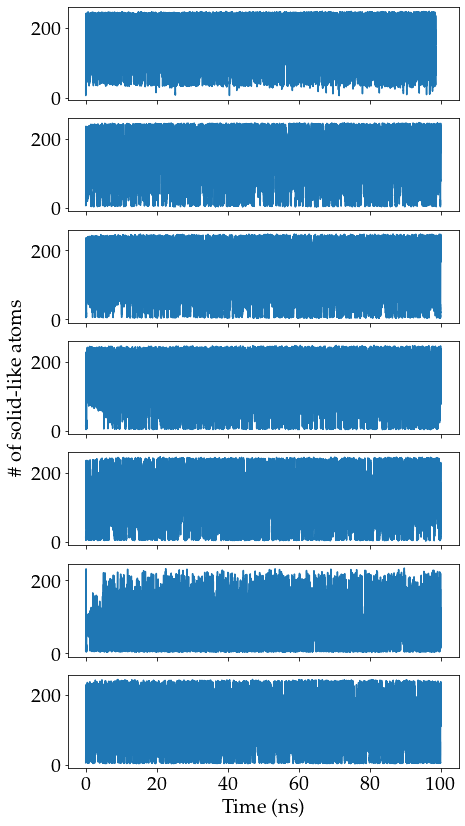

In [11]:
temperatures=np.arange(360,430,10)
plt.rcParams["figure.figsize"] = (3.5*2,7*2)
fig, axs= plt.subplots(temperatures.shape[0],sharex=True) #,sharey=True)

for i in range(temperatures.shape[0]):
    string=str(int(temperatures[i]))
    data=np.genfromtxt("2-bulk-interconversion/250atoms/" + string + "K/COLVAR")
    axs[i].plot(data[:,0]/1000,data[:,2])

axs[temperatures.shape[0]-1].set_xlabel("Time (ns)")
axs[int(temperatures.shape[0]/2)].set_ylabel("\# of solid-like atoms")

plt.show()

### Trajectory visualization at 380 K

#### 250 atoms

In [13]:
conf = aseio.read("2-bulk-interconversion/250atoms/380K/dump.na",index=':',format='lammps-dump-text')
v = nglview.show_asetraj(conf)
v.camera = 'orthographic'
display(v)

NGLWidget(max_frame=413)

#### 1024 atoms

In [35]:
conf = aseio.read("2-bulk-interconversion/1024atoms/380K/dump.na",index=':',format='lammps-dump-text')
v = nglview.show_asetraj(conf)
v.camera = 'orthographic'
display(v)

NGLWidget(max_frame=600)

/tmp/ipykernel_4143426/2092285579.py:17: RuntimeWarning: divide by zero encountered in log
  fes=-(1./beta)*np.log(hist)


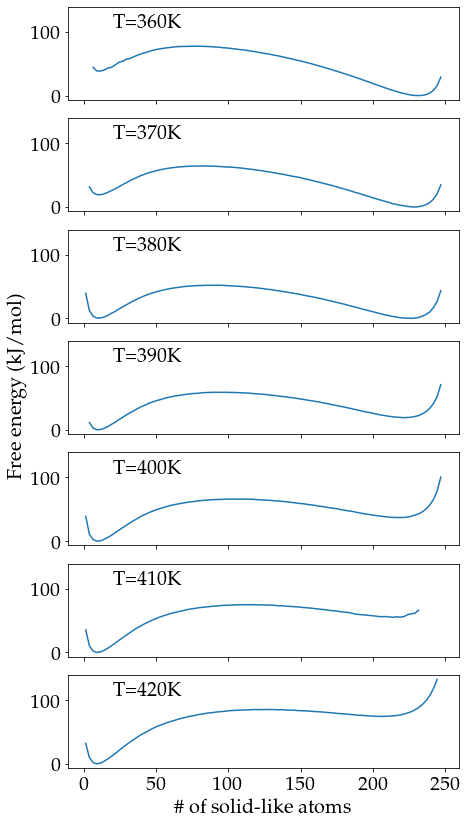

In [17]:
temperatures=np.arange(360,430,10)
plt.rcParams["figure.figsize"] = (3.5*2,7*2)
ignoreN=1000
fig, axs= plt.subplots(temperatures.shape[0],sharex=True,sharey=True)

for i in range(temperatures.shape[0]):
    string=str(int(temperatures[i]))
    data=np.genfromtxt("2-bulk-interconversion/250atoms/" + string + "K/COLVAR")
    bias=data[ignoreN:,3]+data[ignoreN:,10]
    kb=0.008314462618
    beta=1./(kb*temperatures[i])
    logweights=beta*bias
    logweights -= np.amax(logweights)
    cv=data[ignoreN:,2]
    hist, bin_edges = np.histogram(cv,weights=np.exp(logweights),range=(0,256),bins=100)
    bin_centers=(bin_edges[1:]+bin_edges[:-1])/2.
    fes=-(1./beta)*np.log(hist)
    fes -= np.amin(fes)
    axs[i].plot(bin_centers,fes)
    axs[i].text(20,105,"T=" +  string + "K")

axs[temperatures.shape[0]-1].set_xlabel("\# of solid-like atoms")
axs[int(temperatures.shape[0]/2)].set_ylabel("Free energy (kJ/mol)")

plt.show()

In [19]:
def freeEnergy(CV,bias,temperature,CVlimit):
    """Calculate the free energy difference between two phases.

    Args:
        CV (numpy array): An array with the collective variable values
        bias (numpy array): An array with the bias values in kJ/mol
        temperature (float): The temperature in K
        CVlimit (float): Watershed between the two phases (CVunits)

    Returns:
        float: the free energy in kJ/mol
    """
    beta=1./(0.00831441001626*temperature) # 1/(kJ/mol)
    probLiquid=np.sum(np.exp(beta*bias[CV<=CVlimit]))
    probSolid=np.sum(np.exp(beta*bias[CV>=CVlimit]))
    freeEnergy=-(1./beta)*np.log(probSolid/probLiquid)
    return freeEnergy

In [26]:
temperatures=np.arange(370,430,10)
ignoreN=1000
Natoms=250
chemPot250=np.zeros(temperatures.shape[0])
for i in range(temperatures.shape[0]):
    string=str(int(temperatures[i]))
    data=np.genfromtxt("2-bulk-interconversion/250atoms/" + string + "K/COLVAR")
    bias=data[ignoreN:,3]+data[ignoreN:,10]
    cv=data[ignoreN:,2]
    chemPot250[i]=freeEnergy(cv,bias,temperatures[i],100)/Natoms
    

Natoms=1024
chemPot1024=np.zeros(temperatures.shape[0])
for i in range(temperatures.shape[0]):
    string=str(int(temperatures[i]))
    data=np.genfromtxt("2-bulk-interconversion/1024atoms/" + string + "K/COLVAR")
    bias=data[ignoreN:,3]+data[ignoreN:,10]
    cv=data[ignoreN:,2]
    chemPot1024[i]=freeEnergy(cv,bias,temperatures[i],500)/Natoms

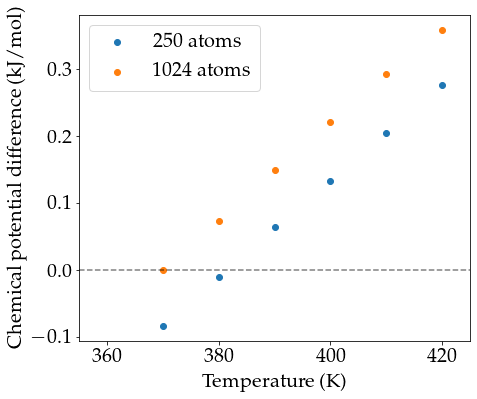

In [31]:
plt.rcParams["figure.figsize"] = (3.5*2,3*2)

plt.scatter(temperatures,chemPot250,label="250 atoms")
plt.scatter(temperatures,chemPot1024,label="1024 atoms")
plt.plot([355,425],[0,0],'--',color='black',alpha=0.5)
plt.xlim([355,425])

plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Chemical potential difference (kJ/mol)")
plt.show()

In [23]:
def func(x, a, b):
    return a * x + b

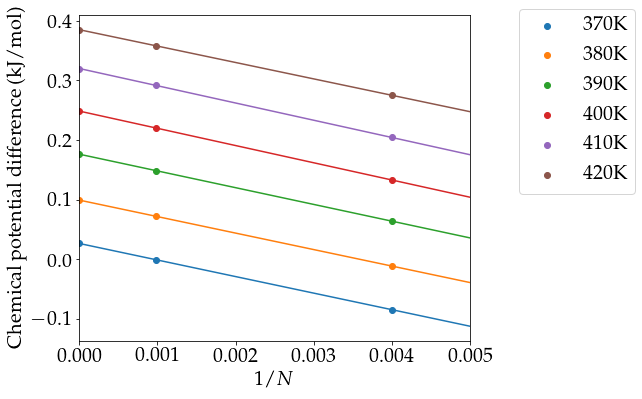

In [34]:
#plt.scatter((1./250.)*np.ones(chemPot250.shape[0]),chemPot250)
#plt.scatter((1./1024.)*np.ones(chemPot1024.shape[0]),chemPot1024)

chemPot=np.zeros(chemPot1024.shape[0])
xdata=np.array([(1./250.),(1./1024.)])
x=np.linspace(0,0.005,100)
for i in range(chemPot1024.shape[0]):
    ydata=np.array([chemPot250[i],chemPot1024[i]])
    plt.scatter(xdata,ydata,color=colors[i])
    popt, pcov = curve_fit(func, xdata, ydata)
    plt.plot(x,func(x,*popt),color=colors[i])
    chemPot[i]=popt[1]
    plt.scatter([0],[chemPot[i]],color=colors[i],label=str(int(temperatures[i])) + "K")

plt.xlabel(r"$1/N$")
plt.ylabel("Chemical potential difference (kJ/mol)")

plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.xlim([0,0.005])
plt.show()

250 atoms - Melting T at 1 bar -  381.5282198463571
1024 atoms - Melting T at 1 bar -  369.7889086580319
Infinite atoms - Melting T at 1 bar -  366.0169275382722


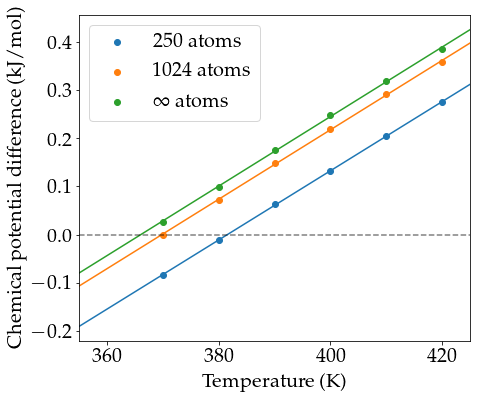

In [36]:
plt.rcParams["figure.figsize"] = (3.5*2,3*2)

x=np.linspace(355,425,100)

popt, pcov = curve_fit(func, temperatures,chemPot250)
plt.scatter(temperatures,chemPot250,color=colors[0],label="250 atoms")
plt.plot(x,func(x,*popt),color=colors[0])

print("250 atoms - Melting T at 1 bar - ",-popt[1]/popt[0])

popt, pcov = curve_fit(func, temperatures,chemPot1024)
plt.scatter(temperatures,chemPot1024,color=colors[1],label="1024 atoms")
plt.plot(x,func(x,*popt),color=colors[1])

print("1024 atoms - Melting T at 1 bar - ",-popt[1]/popt[0])

popt, pcov = curve_fit(func, temperatures,chemPot)
plt.scatter(temperatures,chemPot,color=colors[2],label=r'$\infty$ atoms')
plt.plot(x,func(x,*popt),color=colors[2])

print("Infinite atoms - Melting T at 1 bar - ",-popt[1]/popt[0])

plt.plot([355,425],[0,0],'--',color='black',alpha=0.5)
plt.xlim([355,425])
plt.xlabel("Temperature (K)")
plt.ylabel("Chemical potential difference (kJ/mol)")

plt.legend()

plt.show()

A system size  2000.0  has an error of ~1 K


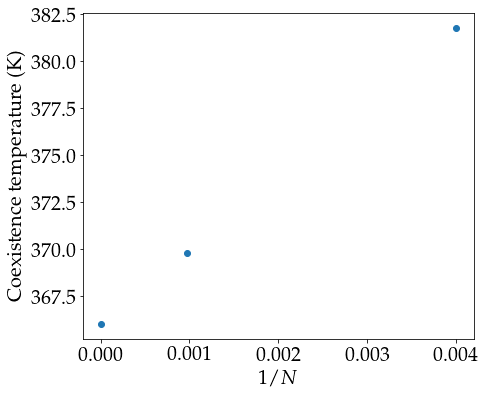

In [38]:
plt.rcParams["figure.figsize"] = (3.5*2,3*2)

plt.scatter(np.array([1./250.,1./1024.,0]),np.array([381.767,369.7889,366.01]))
print("A system size ", 1/0.0005," has an error of ~1 K")
plt.ylabel("Coexistence temperature (K)")
plt.xlabel(r"$1/N$")
plt.show()

## Exercise 3: Biased coexistence

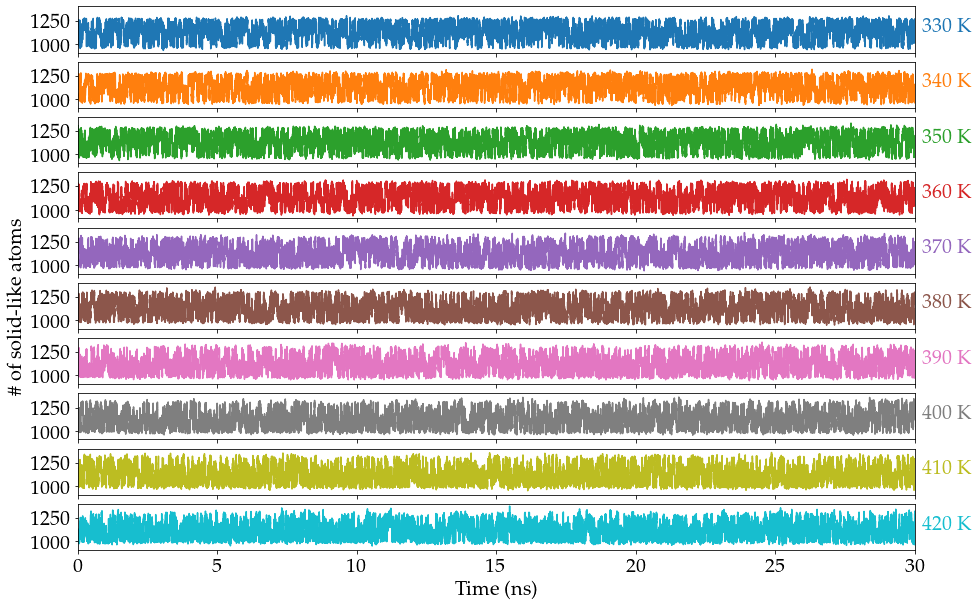

In [46]:
plt.rcParams['figure.figsize'] = (15, 10)

temps=np.array([330,340,350,360,370,380,390,400,410,420])
fig, axs = plt.subplots(temps.shape[0],sharex=True,sharey=True)
counter1=0
for temp in temps:
    file="3-biased-coexistence/2048atoms/" + str(temp) + "K" + '/COLVAR'
    if(os.path.exists(file)):
        data = np.genfromtxt(file)
        axs[counter1].plot(data[:,0]/1000,data[:,13],color=colors[counter1])
        axs[counter1].text(30.25,1125,str(temp) + " K",color=colors[counter1])
    counter1 += 1

axs[temps.shape[0]-1].set_xlabel("Time (ns)")
axs[int(temps.shape[0]/2)].set_ylabel("\# of solid-like atoms")
axs[0].set_xlim([0,30])
plt.show()

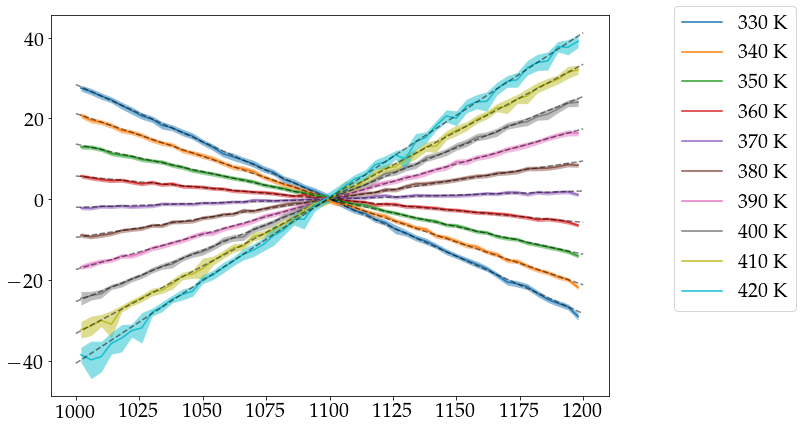

In [51]:
plt.rcParams['figure.figsize'] = (10, 7)

def func(x,a,b):
    return a*x+b

chemical_potentials_bc_2048=np.zeros(temps.shape[0])
chemical_potentials_errors_bc_2048=np.zeros(temps.shape[0])
counter1=0
for temp in temps:
    file="3-biased-coexistence/2048atoms/" + str(temp) + "K" + '/COLVAR'
    if(os.path.exists(file)):
        data = np.genfromtxt(file)
        ignore=int(data.shape[0]/8)
        bias= data[ignore:,3]+data[ignore:,8]+data[ignore:,10]
        cv=data[ignore:,13]
        if (cv.shape[0]>0):
            beta=1./(0.00831441001626*temp)
            logweights=beta*bias
            logweights -= np.amax(logweights)
            nbins=50
            histmin=1000
            histmax=1200
            histo, bin_edges = np.histogram(cv,weights=np.exp(logweights),bins=nbins,range=(histmin,histmax))
            err = np.sqrt(np.histogram(cv,weights=np.power(np.exp(logweights),2),bins=nbins,range=(histmin,histmax))[0])
            bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
            fes = -(1/beta)*np.log(histo)
            offset = np.mean(np.ma.masked_invalid(fes))
            fes -= offset
            plt.plot(bin_centers,fes,color=colors[counter1],label=str(temp) + " K")
            feserr = (1/beta)*err/histo
            plt.fill_between(bin_centers,fes-3*feserr,fes+3*feserr,color=colors[counter1],linewidth=0,alpha=0.5)
            if (fes[np.isfinite(fes)].shape[0]>0):
                popt, pcov = curve_fit(func, bin_centers[np.isfinite(fes)], fes[np.isfinite(fes)], sigma=feserr[np.isfinite(fes)])
                x=np.linspace(histmin,histmax,10)
                plt.plot(x,func(x,*popt),'--',color='black',alpha=0.5)
                chemical_potentials_bc_2048[counter1]=popt[0]
                perr = np.sqrt(np.diag(pcov))
                chemical_potentials_errors_bc_2048[counter1]=perr[0]
    counter1 += 1

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

2048 atoms - Melting T at 1 bar -  367.30183771656806


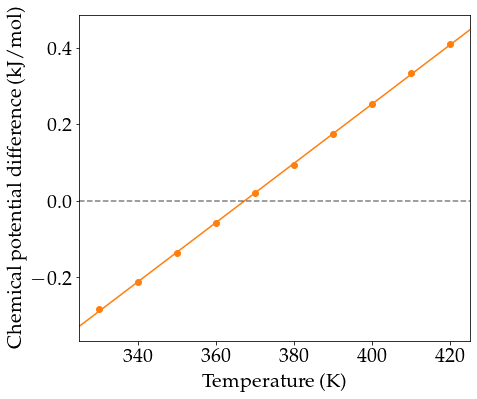

In [54]:
plt.rcParams["figure.figsize"] = (3.5*2,3*2)

x=np.linspace(325,425,100)

popt, pcov = curve_fit(func, temps,chemical_potentials_bc_2048)
plt.scatter(temps,chemical_potentials_bc_2048,color=colors[1],label="BC - 2048 atoms")
plt.plot(x,func(x,*popt),color=colors[1])

print("2048 atoms - Melting T at 1 bar - ",-popt[1]/popt[0])

plt.plot([325,425],[0,0],'--',color='black',alpha=0.5)
plt.xlim([325,425])
plt.xlabel("Temperature (K)")
plt.ylabel("Chemical potential difference (kJ/mol)")

plt.show()

In [72]:
conf = aseio.read("3-biased-coexistence/2048atoms/370K/dump.na",index=':',format='lammps-dump-text')
v = nglview.show_asetraj(conf)
v.camera = 'orthographic'
v.control.spin([0, 1, 0], np.pi/2)
display(v)

NGLWidget(max_frame=400)

## Exercise 4: Thermodynamic integration along isobars

In [56]:
numAtoms=1024
temps=np.arange(330,430,10)
enthalpy_liquid=np.zeros(temps.shape[0])
enthalpy_bcc=np.zeros(temps.shape[0])
counter=0
for temp in temps:
    enthalpy_liquid[counter]=np.mean(np.genfromtxt("4-thermodynamic-integration/liquid/" + str(int(temp)) + "K/thermo.txt")[:,1])*96.4853075/numAtoms
    enthalpy_bcc[counter]=np.mean(np.genfromtxt("4-thermodynamic-integration/bcc/" + str(int(temp)) + "K/thermo.txt")[:,1])*96.4853075/numAtoms
    counter+=1

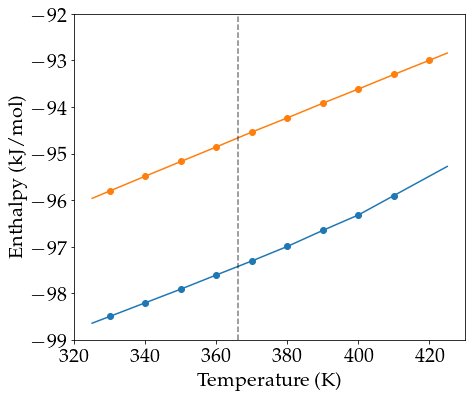

In [57]:
plt.scatter(temps[:-1],enthalpy_bcc[:-1])
plt.scatter(temps,enthalpy_liquid)
f_bcc = interpolate.interp1d(temps[:-1],enthalpy_bcc[:-1],fill_value="extrapolate") #,kind='cubic')
f_liquid = interpolate.interp1d(temps,enthalpy_liquid,fill_value="extrapolate") #,kind='cubic')
x=np.linspace(325,425,100)
plt.plot(x,f_bcc(x))
plt.plot(x,f_liquid(x))
plt.plot([366,366],[-99,-92],'--',color='black',alpha=0.5)
plt.ylim([-99,-92])
plt.xlabel("Temperature (K)")
plt.ylabel("Enthalpy (kJ/mol)")
plt.show()

In [58]:
f_diff = interpolate.interp1d(temps[:-1],enthalpy_liquid[:-1]-enthalpy_bcc[:-1],fill_value="extrapolate") #,kind='cubic')

In [59]:
temps_ti=np.linspace(325,425,100)
chemical_potential_ti=np.zeros(temps_ti.shape[0])
for i in range(temps_ti.shape[0]):
    meltingT=366
    dummy_temps=np.linspace(meltingT,temps_ti[i],1000)
    integrand=f_diff(dummy_temps)/np.power(dummy_temps,2)
    chemical_potential_ti[i]=temps_ti[i]*np.trapz(integrand,dummy_temps)

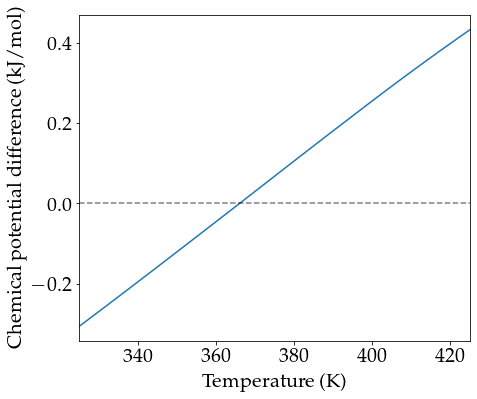

In [60]:
plt.plot(temps_ti,chemical_potential_ti)
plt.plot([325,425],[0,0],'--',color='black',alpha=0.5)
plt.xlim([325,425])
plt.xlabel("Temperature (K)")
plt.ylabel("Chemical potential difference (kJ/mol)")

plt.show()

## Compare all three methods

2048 atoms - Melting T at 1 bar -  367.30183771656806
Infinite atoms - Melting T at 1 bar -  366.0169275382722


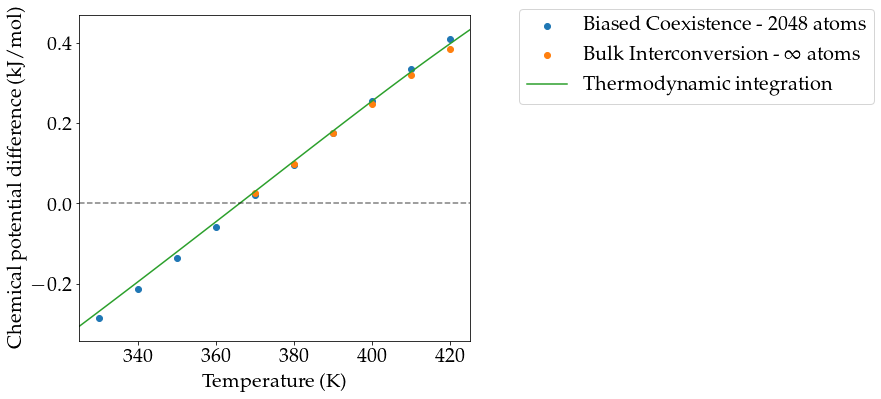

In [66]:
plt.rcParams["figure.figsize"] = (3.5*2,3*2)

x=np.linspace(325,425,100)

popt, pcov = curve_fit(func, temps,chemical_potentials_bc_2048)
plt.scatter(temps,chemical_potentials_bc_2048,color=colors[0],label="Biased Coexistence - 2048 atoms")
#plt.plot(x,func(x,*popt),color=colors[0])

print("2048 atoms - Melting T at 1 bar - ",-popt[1]/popt[0])


popt, pcov = curve_fit(func, temperatures1024,chemPot)
plt.scatter(temperatures1024,chemPot,color=colors[1],label=r'Bulk Interconversion - $\infty$ atoms')
#plt.plot(x,func(x,*popt),"--",color=colors[1])

print("Infinite atoms - Melting T at 1 bar - ",-popt[1]/popt[0])

plt.plot(temps_ti,chemical_potential_ti,color=colors[2],label=r'Thermodynamic integration')


plt.plot([325,425],[0,0],'--',color='black',alpha=0.5)
plt.legend()
plt.xlim([325,425])
plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.xlabel("Temperature (K)")
plt.ylabel("Chemical potential difference (kJ/mol)")
plt.show()

